<a href="https://colab.research.google.com/github/Bdata0/Courseworks/blob/main/Books_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек и данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from PIL import Image
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
pip install wget

In [ ]:
import wget 
url = 'http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip'
filename = wget.download(url)
filename

'BX-CSV-Dump.zip'

In [ ]:
import zipfile as zf

files = zf.ZipFile(filename,'r')
files.extractall('Data')
files.close()

In [ ]:
books = pd.read_csv('Data/BX-Books.csv', sep=';', encoding='latin', error_bad_lines=False)
ratings = pd.read_csv('Data/BX-Book-Ratings.csv', sep=';', encoding='latin', error_bad_lines=False)
users = pd.read_csv('Data/BX-Users.csv', sep=';', encoding='latin', error_bad_lines=False)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:27

In [ ]:
def judge_book_by_its_cover(cover_links,recom_data, filter_level):
    recom_data = recom_data[0:5]
    fig, axs = plt.subplots(1, 5,figsize=(18,5))
    fig.suptitle('You may also like these books', size = 22)
    for i in range(len(recom_data[filter_level].tolist())):

        url = cover_links.loc[cover_links[filter_level] == recom_data[filter_level].tolist()[i],'Image-URL-L'][:1].values[0]
        im = Image.open(requests.get(url, stream=True).raw)
        axs[i].imshow(im)
        axs[i].axis("off")
        axs[i].set_title('Rating: {}'.format(round(recom_data['avg_rating'].tolist()[i],1)),
                        y=-0.18,
                            color="red",
                            fontsize=18)
        fig.show()

## Предобработка данных

In [ ]:
# Проверяем пропуски в данных по книгам
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [ ]:
# Проверяем пропуски в данных по рейтингам
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
# Проверяем пропуски в данных по пользователям
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
# Посмотрим на данные
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
# Сохраним ссылки для визуализаций и опустим для моделей
cover_links = books[['ISBN', 'Book-Title', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']]
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)
cover_links.head()

,ISBN,Book-Title,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [ ]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [ ]:
books = books[(books['Year-Of-Publication'] != 'DK Publishing Inc')
              & (books['Year-Of-Publication'] != 'Gallimard')]

In [ ]:
books['Year-Of-Publication'].astype('int32')

0         2002
1         2001
2         1991
3         1999
4         1999
          ... 
271355    1988
271356    1991
271357    2004
271358    1996
271359    2000
Name: Year-Of-Publication, Length: 271357, dtype: int32

In [ ]:
books = books.dropna()
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271354 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271354 non-null  object
 1   Book-Title           271354 non-null  object
 2   Book-Author          271354 non-null  object
 3   Year-Of-Publication  271354 non-null  object
 4   Publisher            271354 non-null  object
dtypes: object(5)
memory usage: 12.4+ MB


In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [ ]:
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan
users.Age = users.Age.fillna(users.Age.mean())
users.Age = users.Age.astype(np.int32)
print(sorted(users.Age.unique()))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",34
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",34
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",34


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
# В данных по рейтингам, оставляем только те книги, которые присутствуют в данных по книгам
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

In [ ]:
ratings_new.shape

(1031129, 3)

In [ ]:
ratings['Book-Rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [ ]:
# Вычищаем нулевые рейтинги для этого разделяем датасет на явный и неявный рейтинги

ratings_explicit = ratings_new[ratings_new['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings_new['Book-Rating'] == 0]

print(ratings_new.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)

(1031129, 3)
(383838, 3)
(647291, 3)


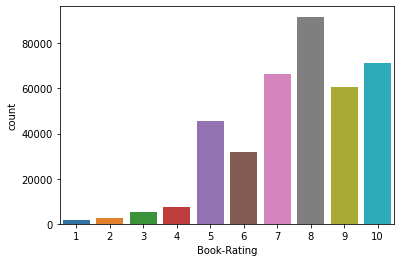

In [ ]:
# Посмотрим на распределение рейтингов

sns.countplot(data=ratings_explicit , x='Book-Rating')

In [ ]:
rating_with_books = ratings.merge(books, on='ISBN')
rating_with_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books


In [ ]:
rating_with_books.shape

(1031129, 7)

In [ ]:
number_rating = rating_with_books.groupby('ISBN')['Book-Rating'].count().reset_index()
number_rating.rename(columns= {'Book-Rating':'number_of_ratings'}, inplace=True)
final_rating = rating_with_books.merge(number_rating, on='ISBN')
final_rating = final_rating[final_rating['number_of_ratings'] >= 50]
final_rating.drop_duplicates(['User-ID','ISBN'], inplace=True)
final_rating

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,number_of_ratings
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,60
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,60
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,60
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,60
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,60
...,...,...,...,...,...,...,...,...
710805,241666,0451180216,0,Interest of Justice,Nancy Taylor Rosenberg,1994,Signet Book,52
710806,242106,0451180216,0,Interest of Justice,Nancy Taylor Rosenberg,1994,Signet Book,52
710807,252347,0451180216,8,Interest of Justice,Nancy Taylor Rosenberg,1994,Signet Book,52
710808,274308,0451180216,0,Interest of Justice,Nancy Taylor Rosenberg,1994,Signet Book,52


## 1. Popularity-based

Чтобы оценить популярность книги, мы будем использовать формулу для расчета рейтинга популярности с IMDB:

rating = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

Где:

R – средний рейтинг книги

v = количество пользователей, которые поставили оценку книге

m = минимальное количество оценок, которые нужны, чтобы книга попала в топ-250 (определяется взятием 80 процентиля по всем оценкам)

C = средняя оценка среди всех данных

In [ ]:
def weighted_rating(v,m,R,C):
    '''
    Calculate the weighted rating
    
    Args:
    v -> average rating for each item (float)
    m -> minimum votes required to be classified as popular (float)
    R -> average rating for the item (pd.Series)
    C -> average rating for the whole dataset (pd.Series)
    
    Returns:
    pd.Series
    '''
    return ( (v / (v + m)) * R) + ( (m / (v + m)) * C )

In [ ]:
vote_count = (
    final_rating
    .groupby('ISBN', as_index=False)
    .agg( {'User-ID':'count', 'Book-Rating':'mean'} )
    )
vote_count.columns = ['ISBN', 'vote_count', 'avg_rating']

vote_count.head()

,ISBN,vote_count,avg_rating
0,000649840X,89,3.573034
1,0007110928,50,4.160000
2,002026478X,69,1.434783
3,0020442203,66,3.833333
4,002542730X,171,3.514620


In [ ]:
# Средняя оценка по всему датасету
C = np.mean(vote_count['avg_rating'])
print(C)

2.985173405053779


In [ ]:
# Минимальное количество оценок, чтобы считаться популярным
m = np.percentile(vote_count['vote_count'], 80)
print(m)

136.0


In [ ]:
# Cредний рейтинг книги
vote_count = vote_count[vote_count['vote_count'] >= m]
R = vote_count['avg_rating']
print(R)
# Количество пользователей, которые поставили оценку книге
v = vote_count['vote_count']
print(v)

4       3.514620
15      2.693878
17      3.802326
24      3.666667
25      4.356890
          ...   
2121    3.697842
2124    3.852349
2128    2.355556
2134    3.932642
2142    3.198157
Name: avg_rating, Length: 434, dtype: float64
4       171
15      147
17      172
24      171
25      283
       ... 
2121    139
2124    149
2128    180
2134    193
2142    217
Name: vote_count, Length: 434, dtype: int64


In [ ]:
vote_count['weighted_rating'] = weighted_rating(v,m,R,C)
vote_count.head()

,ISBN,vote_count,avg_rating,weighted_rating
4,002542730X,171,3.514620,3.280077
15,006016848X,147,2.693878,2.833864
17,0060175400,172,3.802326,3.441505
24,0060391626,171,3.666667,3.364767
25,0060392452,283,4.356890,3.911655


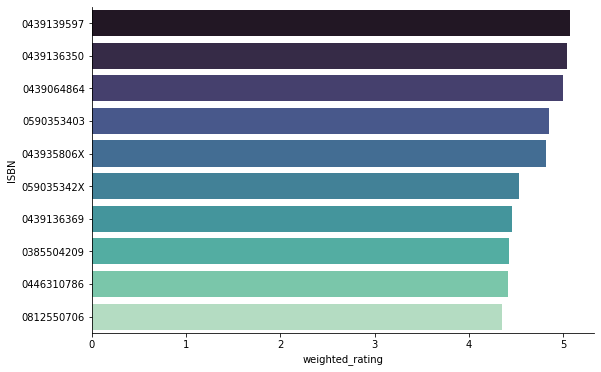

In [ ]:
popular_items = vote_count.sort_values('weighted_rating', ascending = False)

fix, ax = plt.subplots(figsize=(9,6))
sns.barplot(data = popular_items.head(10),
            y = 'ISBN',
            x = 'weighted_rating',
            palette = 'mako');
sns.despine();

In [ ]:
popular_items.head().set_index('ISBN')

,vote_count,avg_rating,weighted_rating
ISBN,,,
0439139597,194,6.541237,5.075708
0439136350,197,6.467005,5.044996
0439064864,170,6.611765,4.999946
0590353403,168,6.363095,4.851920
043935806X,334,5.571856,4.823369


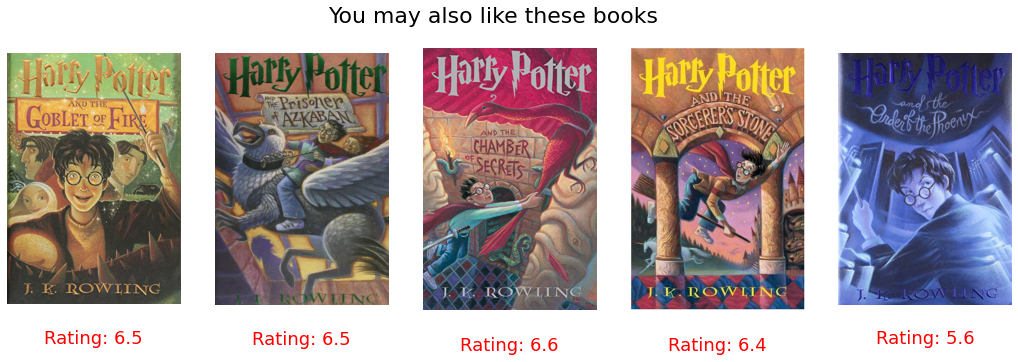

In [ ]:
judge_book_by_its_cover(cover_links, popular_items, "ISBN")

# 2. Рекомендации на основе корреляции

Теперь попробуем посмотреть на данные о рейтингах, которые пользователи давали книгам.

In [ ]:
df = final_rating.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating')
df.head()

Book-Title,16 Lighthouse Road,1984,1st to Die: A Novel,2010: Odyssey Two,204 Rosewood Lane,24 Hours,2nd Chance,3rd Degree,4 Blondes,50 Simple Things You Can Do to Save the Earth,84 Charing Cross Road,A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper)),A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,A Clockwork Orange (Norton Paperback Fiction),A Cold Heart (Alex Delaware Novels (Paperback)),A Cold Heart: An Alex Delaware Novel,A Confederacy of Dunces,A Confederacy of Dunces (Evergreen Book),A Cry In The Night,A Cup of Tea (Ballantine Reader's Circle),A Dangerous Fortune,A Darkness More Than Night,A Day Late and a Dollar Short,A Fine Balance,"A Game of Thrones (A Song of Ice and Fire, Book 1)",A Girl Named Zippy: Growing Up Small in Mooreland Indiana (Today Show Book Club #3),A Great Deliverance,A Heartbreaking Work Of Staggering Genius : A Memoir Based on a True Story,A Heartbreaking Work of Staggering Genius,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Kiss of Shadows (Meredith Gentry Novels (Paperback)),A Lesson Before Dying (Vintage Contemporaries (Paperback)),A Light in the Window (The Mitford Years),A Maiden's Grave,A Man Named Dave: A Story of Triumph and Forgiveness,A Man in Full,...,Whispers and Lies,White Noise (Contemporary American Fiction),White Oleander : A Novel,White Oleander : A Novel (Oprah's Book Club),White Teeth: A Novel,Who Moved My Cheese? An Amazing Way to Deal with Change in Your Work and in Your Life,Why Girls Are Weird : A Novel,Wicked: The Life and Times of the Wicked Witch of the West,Wifey,Wild Animus,Wild Justice,Wild Swans: Three Daughters of China,Windmills of the Gods,Windy City Blues (V.I. Warshawski Novels (Paperback)),Winter Moon,Winter Prey,Winter Solstice,Wish You Well,Without Remorse,Witness in Death (Eve Dallas Mysteries (Paperback)),"Wizard and Glass (The Dark Tower, Book 4)","Wizard's First Rule (Sword of Truth, Book 1)",Women Who Run with the Wolves,Women in His Life,Women of the Silk : A Novel,"Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players",Wouldn't Take Nothing for My Journey Now,Writ of Execution,Writing Down the Bones,Wuthering Heights,Wuthering Heights (Penguin Classics),Wuthering Heights (Wordsworth Classics),Xenocide (Ender Wiggins Saga (Paperback)),YOU BELONG TO ME,Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw""",stardust
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
df['204 Rosewood Lane'].unique()

array([nan,  0.,  7., 10.,  4.,  8.,  5.,  9.])

In [ ]:
def pearson_R(s1, s2):
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))

def recommend(movie_name, df, n):
    reviews = []
    for title in df.columns:
        if title == movie_name:
            continue
        cor = pearson_R(df[movie_name], df[title])
        if np.isnan(cor):
            continue
        else:
            reviews.append((title, cor))
            
    reviews.sort(key = lambda tup: tup[1], reverse = True)
    return reviews[:n]

In [ ]:
recs = recommend('204 Rosewood Lane', df, 10) 
recs

[('Girls Night', 0.24855312479487365),
 ('Cold Blooded', 0.1613700339845094),
 ('Dark Water (Mira Romantic Suspense)', 0.1327551285012954),
 ('16 Lighthouse Road', 0.12673560727640962),
 ('Between Friends', 0.11360318136359504),
 ('The First Time', 0.11022061204738451),
 ('The Main Corpse (Culinary Mysteries (Paperback))', 0.10957568413604668),
 ('The Crush', 0.10724413337809237),
 ('Key of Knowledge (Key Trilogy (Paperback))', 0.10662006700440198),
 ('Firefly Beach', 0.09741624990792067)]

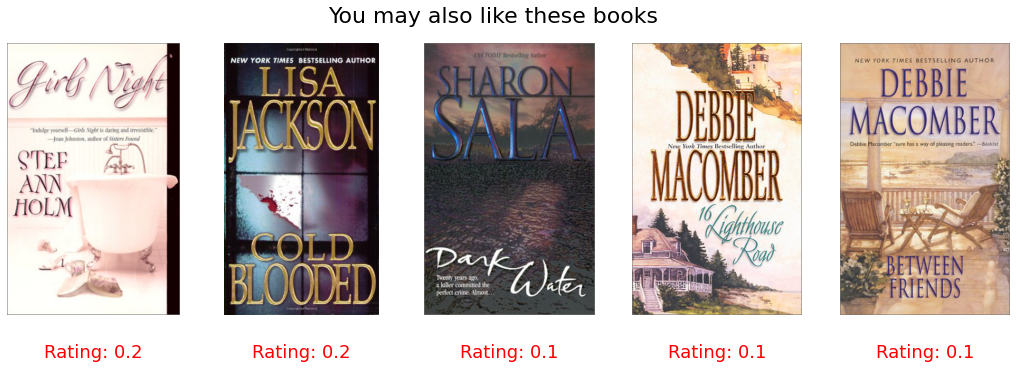

In [ ]:
recs_df = pd.DataFrame(recs, columns=['Book-Title', 'avg_rating'])
judge_book_by_its_cover(cover_links, recs_df, "Book-Title")

# 3. Рекомендации с использованием KNN

In [ ]:
df = final_rating.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)
df.head()

User-ID,9,14,16,17,26,32,39,42,44,51,56,67,75,77,91,95,97,99,114,125,132,133,135,144,165,169,176,178,185,193,207,224,228,230,232,242,243,244,254,256,...,278556,278561,278563,278582,278586,278601,278633,278641,278645,278648,278653,278663,278672,278683,278692,278694,278698,278723,278724,278732,278740,278755,278769,278771,278773,278774,278781,278798,278800,278807,278813,278819,278828,278832,278836,278843,278844,278846,278851,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204 Rosewood Lane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# кол-во книг 2444

df.shape

(1964, 42828)

In [ ]:
ratings_matrix = csr_matrix(df.values)

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
model_knn = NearestNeighbors(metric='cosine', algorithm = 'brute')
model_knn.fit(ratings_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# возьмем любой индекс книги

query_index = np.random.choice(df.shape[0])
print(query_index)

250


In [ ]:
print(df.iloc[query_index,:].values.reshape(1,-1))

[[0. 0. 0. ... 8. 0. 0.]]


In [ ]:
distances, indices = model_knn.kneighbors(df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 11)
df.index[query_index]

'Brave New World'

In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Brave New World:

1: 1984, with distance of 0.8522134484716956:
2: Fahrenheit 451, with distance of 0.8982665404808059:
3: The Death of Vishnu: A Novel, with distance of 0.9049116519041207:
4: Love in the Time of Cholera (Penguin Great Books of the 20th Century), with distance of 0.9122264441303877:
5: Things Fall Apart : A Novel, with distance of 0.9130016275043712:
6: A Clockwork Orange (Norton Paperback Fiction), with distance of 0.9140426541678495:
7: One Hundred Years of Solitude, with distance of 0.9148671945020159:
8: Catch 22, with distance of 0.9174823823244822:
9: Bearing an Hourglass (Incarnations of Immortality (Paperback)), with distance of 0.918318811929607:
10: Foucault's Pendulum, with distance of 0.9186809817720639:
